# Prediction Model of WhistleOut
A supervised learning machine learning model using boosting technique attempts to identify features contributing to transactions done in WhistleOut webpage. Furthermore, the model attempts to sort out a list telling us how important of each main feature is towards transactions and how accurate the prediction can be achieved.

## 1 Data Import
1. Import the master data spreadsheet with relevant columns only.
2. Filter records under Mobile Phone only (not to get confused with Broadband business).
3. Sample the data.

In [1]:
import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV file
csv_file_path = 'FactUTSPageImpression.csv'

# List of columns to import
columns_to_import = [
    'ProductKey', 'CampaignKey', 'SearchCriteriaKey', 'MobilePhoneKey',
    'URLKey', 'LandingURLKey', 'ReferrerURLKey',
    'FirstReferrerURLKey', 'PrevPageURLKey', 'SupplierKey',
    'IsAd', 'IsTransaction',
    'IsProduct', 'PrevID', 'AffiliateName', 'DeviceTypeDesc',
    'ContractLengthMonths', 'ContractLengthDesc', 'ProductAreaName',
    'Source', 'Medium', 'Campaign', 'WOHeadlinePlanFixedDiscount',
    'WOHeadlinePhoneDiscount', 'WOHeadlineExtraDataDiscount',
    'OneOffFeeTotal', 'MonthlyFeeTotal', 'AnnualFeeTotal',
    'Phoneupfrontcost', 'Phonemonthlycost', 'Phonefinancingterm',
    'PhoneEarlyupgradeterm', 'Phoneleaseterm', 'Phonefinancetypedesc'
]

# Read the CSV file into a Pandas DataFrame with the filtering condition
df = pd.read_csv(csv_file_path, usecols=columns_to_import)

# Focus on Mobile Phones transcactions
df = df[df['ProductAreaName'] == 'Mobile Phones']

# Display the first few rows of the DataFrame
df.head()

/tmp/ipykernel_492/3024180527.py:22: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, usecols=columns_to_import)


,ProductKey,CampaignKey,SearchCriteriaKey,MobilePhoneKey,URLKey,LandingURLKey,ReferrerURLKey,FirstReferrerURLKey,SupplierKey,PrevPageURLKey,...,WOHeadlineExtraDataDiscount,OneOffFeeTotal,MonthlyFeeTotal,AnnualFeeTotal,Phoneupfrontcost,Phonemonthlycost,Phonefinancingterm,PhoneEarlyupgradeterm,Phoneleaseterm,Phonefinancetypedesc
2,0,0,1283,0,62097,45538,28187,28187,0,21852.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,0,0,1283,0,22444,40104,66964,84958,0,38226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
10,0,0,1283,0,60333,60333,84958,84958,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
11,0,0,2856,0,30228,34766,34766,72540,0,217852.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
12,0,0,1283,0,46570,220516,220516,0,0,220516.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


## 2 Data Cleaning
1. Remove any columns which may cause confusion to prediction model.
2. Convert columns to categorical values supported by prediction model.

In [2]:
# SearchCrieriaKey has no effect on IsTranaction
df[df['IsTransaction'] == 1]['SearchCriteriaKey'].unique()
# URLKey is also useless as it always shows the URL to purchase
# Campaign is duplicated with CampaignKey

array([0])

In [3]:
# Drop it to avoid XGBoost using it as the sole split
df.drop(columns=['SearchCriteriaKey', 'URLKey', 'Campaign'], inplace=True)
df.head()

,ProductKey,CampaignKey,MobilePhoneKey,LandingURLKey,ReferrerURLKey,FirstReferrerURLKey,SupplierKey,PrevPageURLKey,IsAd,IsTransaction,...,WOHeadlineExtraDataDiscount,OneOffFeeTotal,MonthlyFeeTotal,AnnualFeeTotal,Phoneupfrontcost,Phonemonthlycost,Phonefinancingterm,PhoneEarlyupgradeterm,Phoneleaseterm,Phonefinancetypedesc
2,0,0,0,45538,28187,28187,0,21852.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,0,0,0,40104,66964,84958,0,38226.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
10,0,0,0,60333,84958,84958,0,NaN,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
11,0,0,0,34766,34766,72540,0,217852.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
12,0,0,0,220516,220516,0,0,220516.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
def convertToCat(df):
    # Convert all columns to 'category' data type
    for column in df.columns:
        df[column] = df[column].astype('category')

## 3 Analysis
1. Split the data into label and features.
2. Further split the data into training and testing.
3. Define prediction model algorithm: XGBoost.
4. Train the model.
5. Show feature importance chart.
6. Evaluate the model.

In [5]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def analyze(df):
    # Convert to categorical values for XGBoost
    convertToCat(df)

    # Specify the column to predict (y) and the features (X)
    y_column = 'IsTransaction'
    X_columns = df.columns[df.columns != y_column]

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        df[X_columns], df[y_column], test_size=0.2, random_state=42
    )

    # Initialize and fit an XGBoost model
    model = xgb.XGBClassifier(tree_method='gpu_hist', enable_categorical=True)
    model.fit(X_train, y_train)

    # Plot feature importance
    xgb.plot_importance(model)
    plt.show()

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)

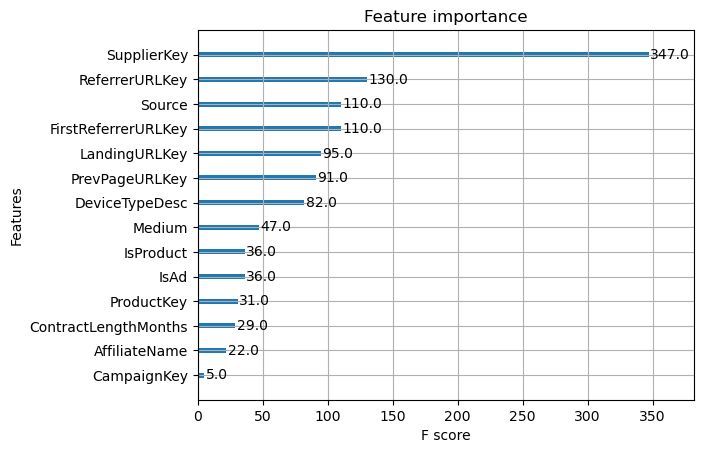

Accuracy: 0.9999211807129205


In [6]:
analyze(df)